CATBOOST

In [ ]:
# ────────────────────────────────────────────────────────────────
#          CELL 1 – Imports
# ────────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Optional: better looking plots
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# ────────────────────────────────────────────────────────────────
#          CELL 2 – Load & Clean Data
# ────────────────────────────────────────────────────────────────

# Change this line to match your actual file name / path
file_path = ('C:/Users/sahan/OneDrive/Desktop/demo python code/MACHINE HEALTH & MAINTENANCE.xlsx')           # ←←← IMPORTANT: CHANGE THIS

df = pd.read_excel(file_path)

# Basic cleaning
df.columns = df.columns.str.strip()            # remove accidental spaces
df = df.dropna(subset=['DefectCount'])         # remove rows missing target
df = df.drop_duplicates()

print("Shape:", df.shape)
print("\nDefectCount statistics:")
print(df['DefectCount'].describe())
print("\nPercentage of zeros:", (df['DefectCount'] == 0).mean() * 100, "%")

Shape: (20000, 10)

DefectCount statistics:
count    20000.000000
mean         2.993550
std          1.737458
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         13.000000
Name: DefectCount, dtype: float64

Percentage of zeros: 4.99 %


In [3]:
# ────────────────────────────────────────────────────────────────
#          CELL 3 – Define features & target
# ────────────────────────────────────────────────────────────────

features = [
    'Temperature', 'Vibration', 'Pressure',
    'EnergyConsumption', 'ProductionUnits',
    'Plant', 'MachineID'
]

target = 'DefectCount'

X = df[features].copy()
y = df[target].copy()

print("Features used:", features)
print("Target:", target)

Features used: ['Temperature', 'Vibration', 'Pressure', 'EnergyConsumption', 'ProductionUnits', 'Plant', 'MachineID']
Target: DefectCount


In [4]:
# ────────────────────────────────────────────────────────────────
#          CELL 4 – Preprocessing pipeline
# ────────────────────────────────────────────────────────────────

num_features = ['Temperature', 'Vibration', 'Pressure', 
                'EnergyConsumption', 'ProductionUnits']
cat_features = ['Plant', 'MachineID']

num_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',  StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    # For CatBoost we skip encoding → it handles categories natively
], remainder='drop')

In [5]:
# ────────────────────────────────────────────────────────────────
#          CELL 5 – Train / Test Split
# ────────────────────────────────────────────────────────────────

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,           # 15% test set (~3000 rows if you have 20k)
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (17000, 7)
Test shape : (3000, 7)


In [6]:
# ────────────────────────────────────────────────────────────────
#          CELL 6 – Option A: Simple CatBoost (Poisson loss)
# ────────────────────────────────────────────────────────────────

from catboost import CatBoostRegressor

cat_idx = [features.index('Plant'), features.index('MachineID')]

model_simple = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.03,
    depth=7,
    loss_function='Poisson',
    eval_metric='MAE',
    random_seed=42,
    verbose=200
)

model_simple.fit(
    X_train, y_train,
    cat_features=cat_idx,
    eval_set=(X_test, y_test),
    early_stopping_rounds=80,
    verbose_eval=200
)

# Predict & evaluate
y_pred_simple = model_simple.predict(X_test)

mae_simple  = mean_absolute_error(y_test, y_pred_simple)
rmse_simple = np.sqrt(mean_squared_error(y_test, y_pred_simple))

print("\n" + "="*60)
print("CatBoost Poisson - Results")
print(f"MAE : {mae_simple:.4f}")
print(f"RMSE: {rmse_simple:.4f}")
print("="*60)

0:	learn: 2.9537899	test: 3.0220745	best: 3.0220745 (0)	total: 245ms	remaining: 6m 6s
200:	learn: 2.0295588	test: 2.0827081	best: 2.0827081 (200)	total: 11.3s	remaining: 1m 13s
400:	learn: 2.0235916	test: 2.0799933	best: 2.0797969 (363)	total: 25.8s	remaining: 1m 10s
Stopped by overfitting detector  (80 iterations wait)

bestTest = 2.079613664
bestIteration = 505

Shrink model to first 506 iterations.

CatBoost Poisson - Results
MAE : 1.3680
RMSE: 1.7316


In [7]:
# ────────────────────────────────────────────────────────────────
#          CELL 7 – Option B: Two-stage model (usually best for many zeros)
# ────────────────────────────────────────────────────────────────

from catboost import CatBoostClassifier

# Stage 1: Binary classifier (zero vs positive)
y_bin_train = (y_train > 0).astype(int)
y_bin_test  = (y_test > 0).astype(int)

clf = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=200
)

clf.fit(
    X_train, y_bin_train,
    cat_features=cat_idx,
    eval_set=(X_test, y_bin_test),
    early_stopping_rounds=60
)

# Stage 2: Count model on positive examples only
pos_mask = y_train > 0

reg = CatBoostRegressor(
    iterations=1800,
    learning_rate=0.025,
    depth=7,
    loss_function='Poisson',
    eval_metric='MAE',
    random_seed=42,
    verbose=200
)

reg.fit(
    X_train[pos_mask], y_train[pos_mask],
    cat_features=cat_idx
)

# Combine predictions
prob_positive = clf.predict_proba(X_test)[:, 1]
count_pred    = reg.predict(X_test)
y_pred_two_stage = prob_positive * count_pred

# Clip extreme values (optional)
y_pred_two_stage = np.clip(y_pred_two_stage, 0, 10)

# Evaluate
mae_two   = mean_absolute_error(y_test, y_pred_two_stage)
rmse_two  = np.sqrt(mean_squared_error(y_test, y_pred_two_stage))

print("\n" + "="*60)
print("Two-Stage CatBoost - Results")
print(f"MAE : {mae_two:.4f}")
print(f"RMSE: {rmse_two:.4f}")
print("="*60)

0:	test: 0.4530863	best: 0.4530863 (0)	total: 83.1ms	remaining: 1m 23s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.4933442245
bestIteration = 127

Shrink model to first 128 iterations.
0:	learn: 3.1149231	total: 50.6ms	remaining: 1m 30s
200:	learn: 2.0484526	total: 10.1s	remaining: 1m 20s
400:	learn: 2.0407564	total: 23.7s	remaining: 1m 22s
600:	learn: 2.0372837	total: 39.2s	remaining: 1m 18s
800:	learn: 2.0346791	total: 55.1s	remaining: 1m 8s
1000:	learn: 2.0327203	total: 1m 11s	remaining: 56.8s
1200:	learn: 2.0310389	total: 1m 33s	remaining: 46.4s
1400:	learn: 2.0296451	total: 1m 48s	remaining: 31s
1600:	learn: 2.0283236	total: 2m 4s	remaining: 15.5s
1799:	learn: 2.0274949	total: 2m 19s	remaining: 0us

Two-Stage CatBoost - Results
MAE : 1.3853
RMSE: 1.7428


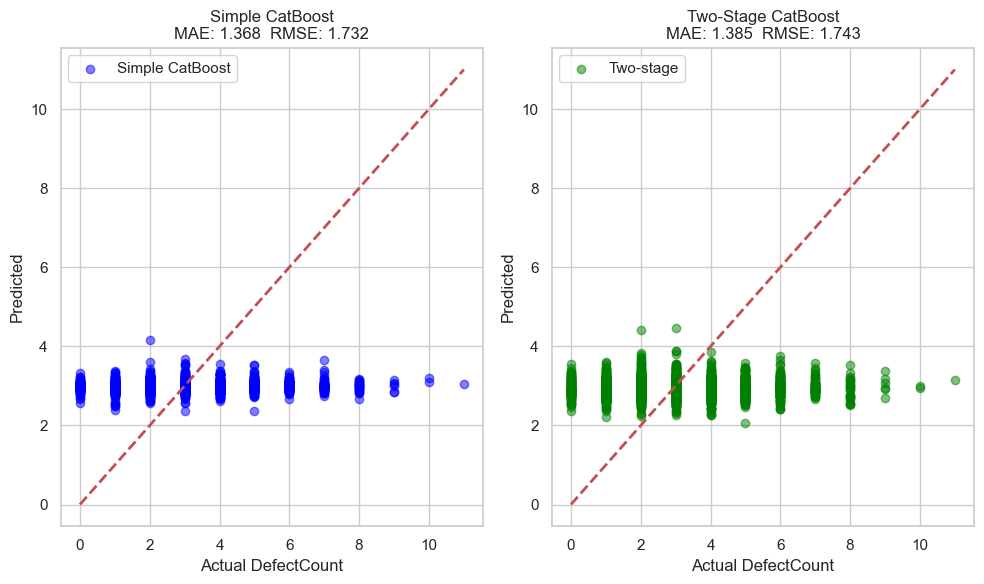

In [8]:
# ────────────────────────────────────────────────────────────────
#          CELL 8 – Visualization: Actual vs Predicted
# ────────────────────────────────────────────────────────────────

plt.figure(figsize=(10, 6))

# Simple CatBoost
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_simple, alpha=0.5, color='blue', label='Simple CatBoost')
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2)
plt.xlabel('Actual DefectCount')
plt.ylabel('Predicted')
plt.title(f'Simple CatBoost\nMAE: {mae_simple:.3f}  RMSE: {rmse_simple:.3f}')
plt.legend()

# Two-stage
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_two_stage, alpha=0.5, color='green', label='Two-stage')
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2)
plt.xlabel('Actual DefectCount')
plt.ylabel('Predicted')
plt.title(f'Two-Stage CatBoost\nMAE: {mae_two:.3f}  RMSE: {rmse_two:.3f}')
plt.legend()

plt.tight_layout()
plt.show()